# SWMAL Exercise

## Pipelines

In [2]:
%matplotlib inline

import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def LoadDataFromL01():
    filename = "itmal_l01_data.pkl"
    with open(f"{filename}", "rb") as f:
        (X, y) = pickle.load(f)
        return X, y

X, y = LoadDataFromL01()

print(f"X.shape={X.shape},  y.shape={y.shape}")

assert X.shape[0] == y.shape[0]
assert X.ndim == 2
assert y.ndim == 1  # did a y.ravel() before saving to picke file
assert X.shape[0] == 29

# re-create plot data (not stored in the Pickel file)
m = np.linspace(0, 60000, 1000)
M = np.empty([m.shape[0], 1])
M[:, 0] = m

print("OK")

X.shape=(29, 1),  y.shape=(29,)
OK


###  Revisiting the problem with the MLP

The MLP may mis-fit the data, seen in the, sometimes, bad R^2 score..

lin.reg.score(X, y)=0.73
    MLP.score(X, y)=-5.86

OK


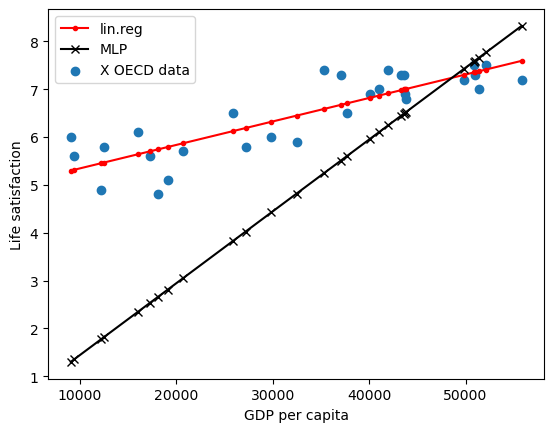

In [3]:
# Setup the MLP and lin. regression again..

def isNumpyData(t: np.ndarray, expected_ndim: int):
    assert isinstance(expected_ndim, int), f"input parameter 'expected_ndim' is not an integer but a '{type(expected_ndim)}'"
    assert expected_ndim>=0, f"expected input parameter 'expected_ndim' to be >=0, got {expected_ndim}"
    if t is None:
        print("input parameter 't' is None", file=sys.stderr)
        return False
    if not isinstance(t, np.ndarray):
        print("excepted numpy.ndarray got type '{type(t)}'", file=sys.stderr)
        return False
    if not t.ndim==expected_ndim:
        print("expected ndim={expected_ndim} but found {t.ndim}", file=sys.stderr)
        return False
    return True

def PlotModels(model1, model2, X: np.ndarray, y: np.ndarray, name_model1: str, name_model2: str):
    
    # NOTE: local function is such a nifty feature of Python!
    def CalcPredAndScore(model, X: np.ndarray, y: np.ndarray,):
        assert isNumpyData(X, 2) and isNumpyData(y, 1) and X.shape[0]==y.shape[0]
        y_pred_model = model.predict(X)
        score_model = r2_score(y, y_pred_model) # call r2
        return y_pred_model, score_model    

    assert isinstance(name_model1, str) and isinstance(name_model2, str)

    y_pred_model1, score_model1 = CalcPredAndScore(model1, X, y)
    y_pred_model2, score_model2 = CalcPredAndScore(model2, X, y)

    plt.plot(X, y_pred_model1, "r.-")
    plt.plot(X, y_pred_model2, "kx-")
    plt.scatter(X, y)
    plt.xlabel("GDP per capita")
    plt.ylabel("Life satisfaction")
    plt.legend([name_model1, name_model2, "X OECD data"])

    l = max(len(name_model1), len(name_model2))
    
    print(f"{(name_model1).rjust(l)}.score(X, y)={score_model1:0.2f}")
    print(f"{(name_model2).rjust(l)}.score(X, y)={score_model2:0.2f}")

# lets make a linear and MLP regressor and redo the plots
mlp = MLPRegressor(hidden_layer_sizes=(10, ),
                   solver='adam',
                   activation='relu',
                   tol=1E-5,
                   max_iter=100000,
                   verbose=False)
linreg = LinearRegression()

mlp.fit(X, y)
linreg.fit(X, y)

print("The MLP may mis-fit the data, seen in the, sometimes, bad R^2 score..\n")
PlotModels(linreg, mlp, X, y, "lin.reg", "MLP")
print("\nOK")

### Qa) Create a Min/max scaler for the MLP

In this assignment we have made a function that shows how we can calculate the scaler for an MLP. 
We calculate the scaler by using this equation for normalization which is describe on page 65 which states "subtracting the min value and dividing by the max minus the min"

X′ = X − X_min /X_max−X_min
​
After using the new scaler we can retrain our MLP

LinReg.score(X, y)=0.73
   MLP.score(X, y)=0.72

OK


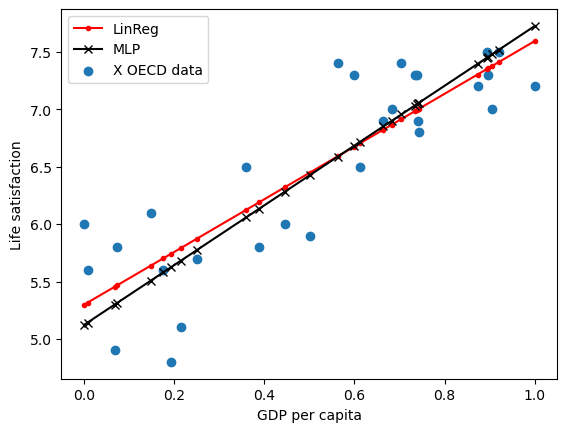

In [4]:

def manualminmaxscaler(data): 
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    scaled_data = (data - data_min) / (data_max - data_min)
    return scaled_data

scaled_X = manualminmaxscaler(X)

mlp.fit(scaled_X,y)
linreg.fit(scaled_X,y)
PlotModels(linreg,mlp, scaled_X,y,"LinReg","MLP")
print(f"\nOK")

### Qb) Scikit-learn Pipelines
In this assignment we are going to be using a pipeline to help simplify running our scaler and fitting our MLP model once again. It does this by running MinMaxScaler() and mlp.fit() whenever we run pipeline.fit

LinReg.score(X, y)=0.73
   MLP.score(X, y)=0.71


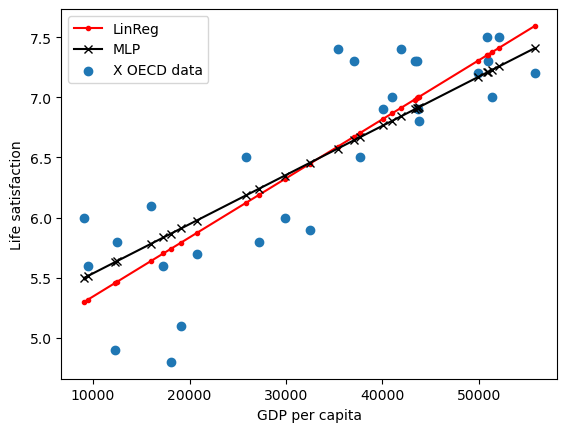

In [5]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    [
        ('Scaler',MinMaxScaler()),
        ('mlp',mlp)
    ]
)
pipeline.fit(X,y)
linreg.fit(X,y)
PlotModels(linreg, pipeline, X, y, "LinReg", "MLP")

### Qc) Outliers and the Min-max Scaler vs. the Standard Scaler
"The main problem with a min-max scaler and outliers is that outliers can significantly impact the scaling process. The min-max scaler works by compressing the data into a range between 0 and 1 based on the minimum and maximum values. If there are outliers with extremely high or low values, they can distort this range, causing the majority of the data to be compressed into a very small interval, which may not accurately represent the overall distribution of the data.

Using sklearn.preprocessing.StandardScaler is generally more effective when dealing with abnormal feature values or outliers. Unlike the min-max scaler, the standard scaler is less influenced by extreme values. It centers the data by subtracting the mean and scales it by dividing by the standard deviation, making it a more robust choice for maintaining accurate scaling in the presence of outliers." answered by chatGPT

LinReg.score(X, y)=0.73
   MLP.score(X, y)=0.74


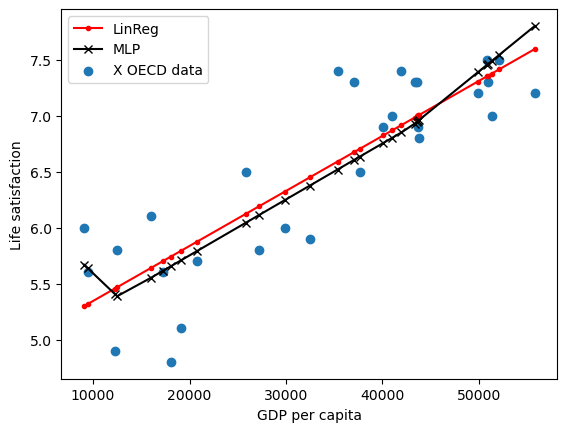

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipelineStandard = Pipeline(
    [
        ('Scaler',StandardScaler()),
        ('mlp',mlp)
    ]
)

pipelineStandard.fit(X,y)
linreg.fit(X,y)
PlotModels(linreg, pipelineStandard, X, y, "LinReg", "MLP")

### Qd) Modify the MLP Hyperparameters
In this segment we want to look at the hyperparameters for the MLP. What differences will we see, when we change the values of the hyperparameters. 
Furthermore we want to test how few neurons the MLP can do with to still produce a sensible (𝑅^2).
Lastly we will look at some other activation functions and solvers.  

LinReg.score(X, y)=0.73
   MLP.score(X, y)=0.70


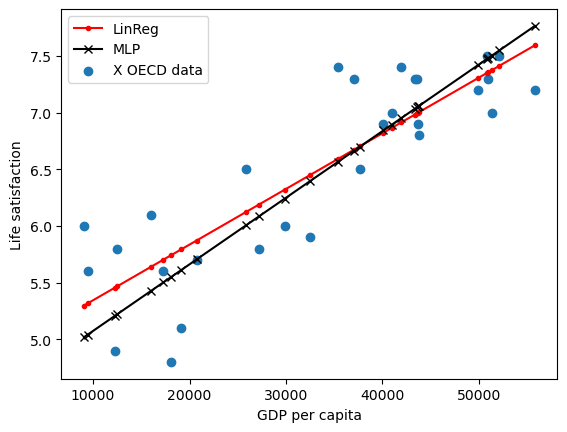

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import random

mlp = MLPRegressor(
    hidden_layer_sizes=(6, ),
    solver='adam',
    activation='relu',
    tol=1E-5,
    max_iter=100000,
    verbose=False)

final6neuronpipe = Pipeline(
    [
        ('Scaler',MinMaxScaler()),
        ('mlp',mlp)
    ]
)


final6neuronpipe.fit(X,y)
linreg.fit(X,y)
PlotModels(linreg, final6neuronpipe, X, y, "LinReg", "MLP")


We start of with 6 hidden layers and find that the R2 for linReg and mlp are more or less the same.

LinReg.score(X, y)=0.73
   MLP.score(X, y)=0.73


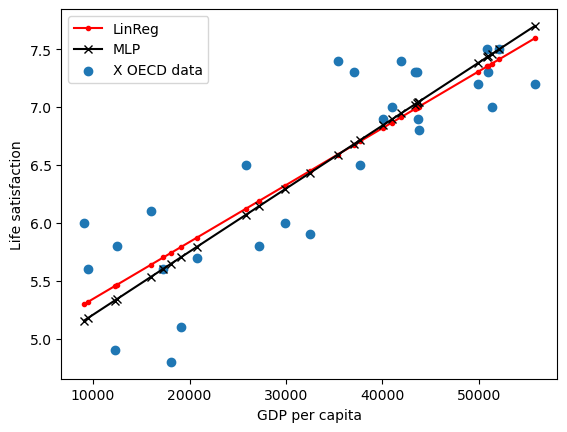

In [94]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

mlp = MLPRegressor(
    hidden_layer_sizes=(4, ),
    solver='adam',
    activation='relu',
    tol=1E-5,
    max_iter=100000,
    verbose=False)

final4neuronpipe = Pipeline(
    [
        ('Scaler',MinMaxScaler()),
        ('mlp',mlp)
    ]
)
final4neuronpipe.fit(X,y)
linreg.fit(X,y)
PlotModels(linreg, final4neuronpipe, X, y, "LinReg", "MLP")

With 4 layers they are still more or less the same. 

LinReg.score(X, y)=0.73
   MLP.score(X, y)=0.72


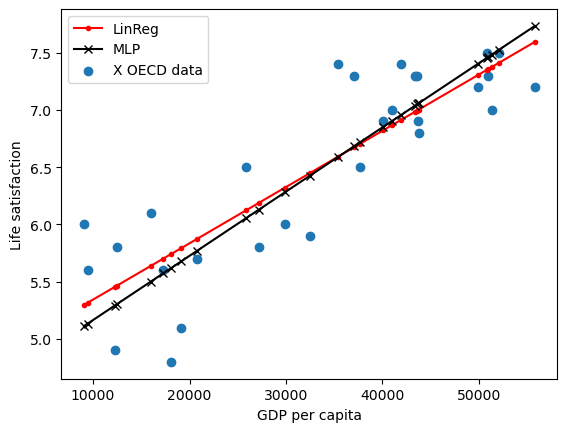

In [95]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

mlp = MLPRegressor(
    hidden_layer_sizes=(3, ),
    solver='adam',
    activation='relu',
    tol=1E-5,
    max_iter=100000,
    verbose=False)

final3neuronpipe = Pipeline(
    [
        ('Scaler',MinMaxScaler()),
        ('mlp',mlp)
    ]
)
final3neuronpipe.fit(X,y)
linreg.fit(X,y)
PlotModels(linreg, final3neuronpipe, X, y, "LinReg", "MLP")

With 3 layers they are still more or less the same. 

LinReg.score(X, y)=0.73
   MLP.score(X, y)=0.73


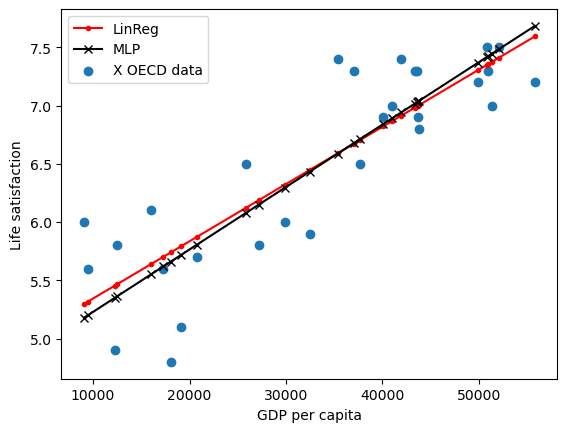

In [100]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


mlp = MLPRegressor(
    hidden_layer_sizes=(2, ),
    solver='adam',
    activation='relu',
    tol=1E-5,
    max_iter=100000,
    verbose=False)

final2neuronpipe = Pipeline(
    [
        ('Scaler',MinMaxScaler()),
        ('mlp',mlp)
    ]
)
final2neuronpipe.fit(X,y)
linreg.fit(X,y)
PlotModels(linreg, final2neuronpipe, X, y, "LinReg", "MLP")

With 2 hidden layers we mostly get scores that still are quit similar.

LinReg.score(X, y)=0.73
   MLP.score(X, y)=-0.01


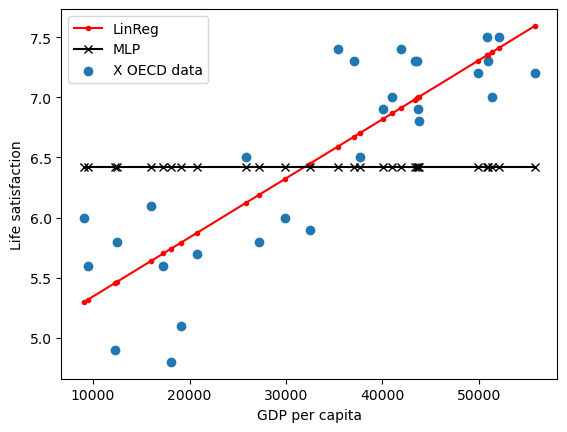

In [108]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


mlp = MLPRegressor(
    hidden_layer_sizes=(1, ),
    solver='adam',
    activation='relu',
    tol=1E-5,
    max_iter=100000,
    verbose=False)

final1neuronpipe = Pipeline(
    [
        ('Scaler',MinMaxScaler()),
        ('mlp',mlp)
    ]
)
final1neuronpipe.fit(X,y)
linreg.fit(X,y)
PlotModels(linreg, final1neuronpipe, X, y, "LinReg", "MLP")

Lastly we try with 1 hidden layer and the score mostly settelse around 0.00

LinReg.score(X, y)=0.73
   MLP.score(X, y)=0.71


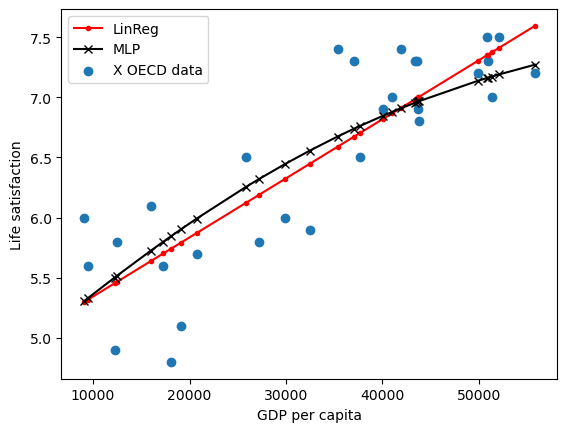

In [119]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

mlp = MLPRegressor(
    hidden_layer_sizes=(4, ),
    solver='adam',
    activation='logistic',
    tol=1E-5,
    max_iter=100000,
    verbose=False)

final_log4_neuronpipe = Pipeline(
    [
        ('Scaler',MinMaxScaler()),
        ('mlp',mlp)
    ]
)
final_log4_neuronpipe.fit(X,y)
linreg.fit(X,y)
PlotModels(linreg, final_log4_neuronpipe, X, y, "LinReg", "MLP")

LinReg.score(X, y)=0.73
   MLP.score(X, y)=0.71


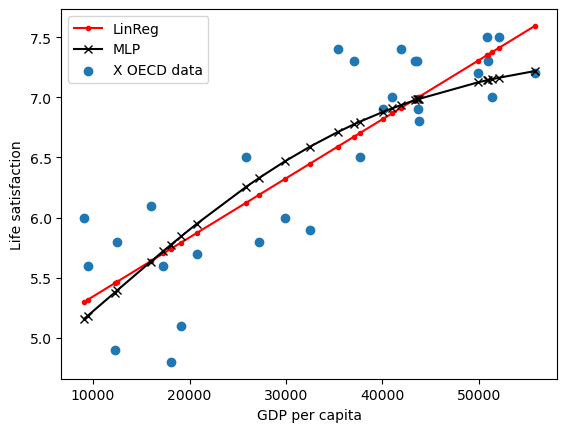

In [159]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

mlp = MLPRegressor(
    hidden_layer_sizes=(1, ),
    solver='adam',
    activation='logistic',
    tol=1E-5,
    max_iter=100000,
    verbose=False)

final_log1_neuronpipe = Pipeline(
    [
        ('Scaler',MinMaxScaler()),
        ('mlp',mlp)
    ]
)
final_log1_neuronpipe.fit(X,y)
linreg.fit(X,y)
PlotModels(linreg, final_log1_neuronpipe, X, y, "LinReg", "MLP")

We tried using the activation function 'sigmoid' and found that it produces more or less the same scores no matter if you use 4 layers or 1 layer.

LinReg.score(X, y)=0.73
   MLP.score(X, y)=-0.13


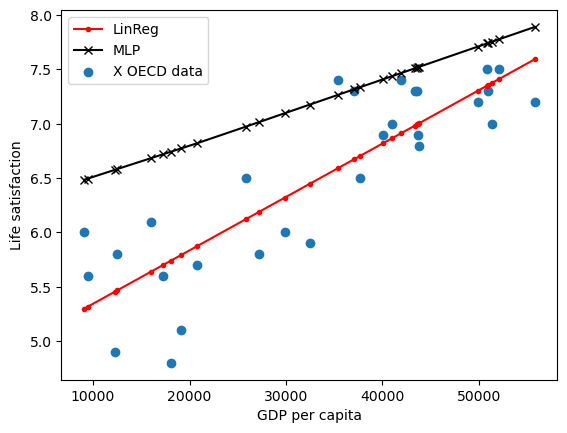

In [139]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

mlp = MLPRegressor(
    hidden_layer_sizes=(10, ),
    solver='sgd',
    activation='relu',
    tol=1E-5,
    max_iter=100000,
    verbose=False)

final_sgd10_solverpipe = Pipeline(
    [
        ('Scaler',MinMaxScaler()),
        ('mlp',mlp)
    ]
)
final_sgd10_solverpipe.fit(X,y)
linreg.fit(X,y)
PlotModels(linreg, final_sgd10_solverpipe, X, y, "LinReg", "MLP")

LinReg.score(X, y)=0.73
   MLP.score(X, y)=0.13


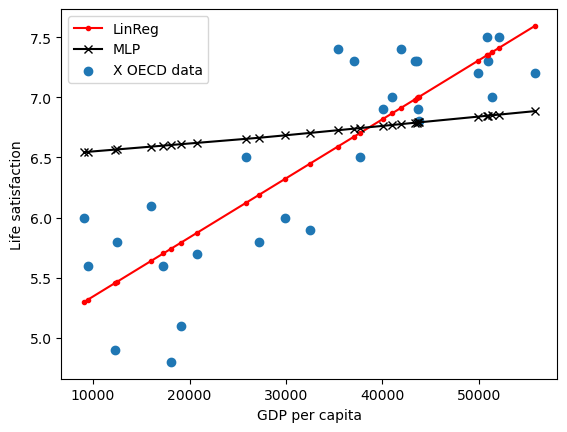

In [137]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

mlp = MLPRegressor(
    hidden_layer_sizes=(5, ),
    solver='sgd',
    activation='relu',
    tol=1E-5,
    max_iter=100000,
    verbose=False)

final_sgd5_solverpipe = Pipeline(
    [
        ('Scaler',MinMaxScaler()),
        ('mlp',mlp)
    ]
)
final_sgd5_solverpipe.fit(X,y)
linreg.fit(X,y)
PlotModels(linreg, final_sgd5_solverpipe, X, y, "LinReg", "MLP")

LinReg.score(X, y)=0.73
   MLP.score(X, y)=-0.00


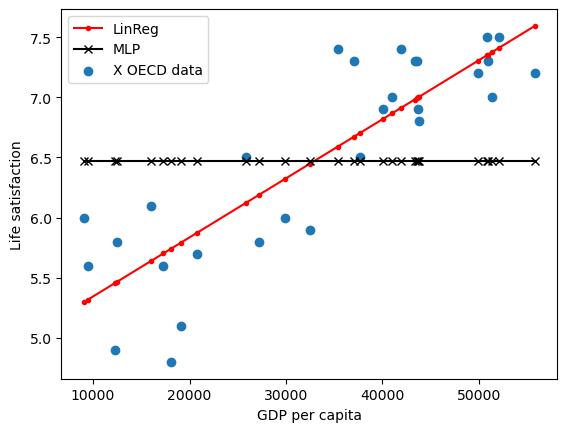

In [122]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

mlp = MLPRegressor(
    hidden_layer_sizes=(1, ),
    solver='sgd',
    activation='relu',
    tol=1E-5,
    max_iter=100000,
    verbose=False)

final_sgd1_solverpipe = Pipeline(
    [
        ('Scaler',MinMaxScaler()),
        ('mlp',mlp)
    ]
)
final_sgd1_solverpipe.fit(X,y)
linreg.fit(X,y)
PlotModels(linreg, final_sgd1_solverpipe, X, y, "LinReg", "MLP")

LinReg.score(X, y)=0.73
   MLP.score(X, y)=0.71


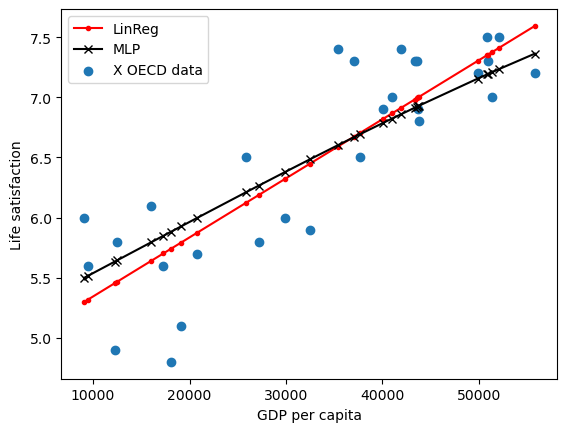

In [163]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

mlp = MLPRegressor(
    hidden_layer_sizes=(8, ),
    solver='sgd',
    activation='logistic',
    tol=1E-5,
    max_iter=100000,
    verbose=False)

final_sgd_log8_solverpipe = Pipeline(
    [
        ('Scaler',MinMaxScaler()),
        ('mlp',mlp)
    ]
)
final_sgd_log8_solverpipe.fit(X,y)
linreg.fit(X,y)
PlotModels(linreg, final_sgd_log8_solverpipe, X, y, "LinReg", "MLP")

LinReg.score(X, y)=0.73
   MLP.score(X, y)=0.18


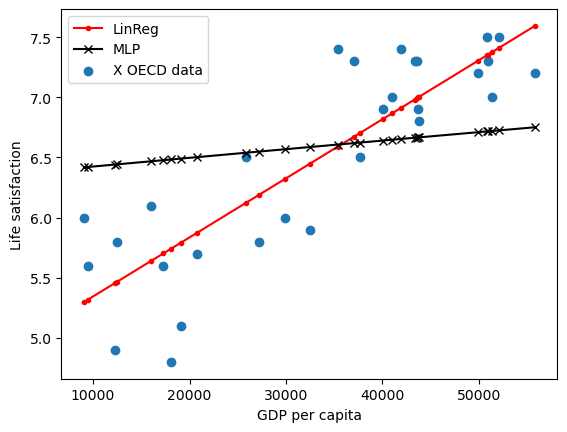

In [165]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

mlp = MLPRegressor(
    hidden_layer_sizes=(10, ),
    solver='sgd',
    activation='logistic',
    tol=1E-5,
    max_iter=100000,
    verbose=False)

final_sgd_log10_solverpipe = Pipeline(
    [
        ('Scaler',MinMaxScaler()),
        ('mlp',mlp)
    ]
)
final_sgd_log10_solverpipe.fit(X,y)
linreg.fit(X,y)
PlotModels(linreg, final_sgd10_solverpipe, X, y, "LinReg", "MLP")

We then tried went back to 'relu' and used the solver 'sgd' and found the no matter how many hidden layers you used the score was way off from the linReg score. But when we changed the activation function to 'logistic' we again experinced similar scores between the linReg and mlp. This was only until we hit 10 hidden layers, then the scores began to change every time you runned them. 

<h1>Conclusion</h1>

__ReLU Activation with Adam Solver__

With 6, 4, 3, and 2 hidden layers, the R2 score for both Linear Regression (LinReg) and MLP (with 'relu' activation function and 'adam' solver) was nearly the same, indicating similar performance between the two models.
With 1 hidden layer, the R2 score was lower, suggesting that the model with fewer hidden layers struggled to capture the complexity in the data.

__Logistic Activation with Adam Solver and 4 Hidden Layers__

By changing the activation function to 'logistic' and using 4 hidden layers, the R2 score for both LinReg and MLP remained comparable. This suggests that the change in activation function did not have a significant impact on the results.

__ReLU Activation with SGD Solver and 10 Hidden Layers__

Using 'sgd' as the solver and 10 hidden layers led to a significant degradation in MLP's performance compared to LinReg. This may indicate that the configuration of 'sgd' with a large number of hidden layers is not suitable for your data and may encounter convergence issues.

__ReLU Activation with SGD Solver and Variable Hidden Layers__

When reverting back to 'relu' activation function with 'sgd' as the solver, we found that scores were far from LinReg scores regardless of the number of hidden layers. This suggests that the combination of 'sgd' and 'relu' led to unstable training, especially as the number of hidden layers increased. Reverting back to 'logistic' activation function brought the scores back to a more comparable state with LinReg.

In summary, the choice of activation functions, solvers, and the number of hidden layers plays a crucial role in the performance of MLP models. Experimentation and careful consideration of these hyperparameters are necessary to optimize the model for specific datasets and tasks. 